Agora que já foi feita a comparação do preprocessamento vou testar as features polynomiais

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [7]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50.0,1120.0,283.0,697.0,264.0,2.1250,140000.0,NEAR BAY,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50.0,2239.0,455.0,990.0,419.0,1.9911,158700.0,NEAR BAY,5.343676,2.362768,0.203216


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17564 non-null  float64
 1   latitude                  17564 non-null  float64
 2   housing_median_age        17564 non-null  float64
 3   total_rooms               17564 non-null  float64
 4   total_bedrooms            17564 non-null  float64
 5   population                17564 non-null  float64
 6   households                17564 non-null  float64
 7   median_income             17564 non-null  float64
 8   median_house_value        17564 non-null  float64
 9   ocean_proximity           17564 non-null  object 
 10  rooms_per_household       17564 non-null  float64
 11  population_per_household  17564 non-null  float64
 12  bedrooms_per_room         17564 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.7+ MB


In [12]:
#na Análise Exploratória foi constatado a relação com localização geográfica
# In the Exploratory Analysis, a relationship with geographical location was found
kmeans = KMeans(n_clusters=5)
#na Análise Exploratória foi constatado a relação com localização geográfica
# In the Exploratory Analysis, a relationship with geographical location was found
df['median_income_cat'] = kmeans.fit_predict(df[['longitude', 'latitude', 'median_income']])



In [13]:
coluna_target=['median_house_value']

coluna_one_hot_encoder=['ocean_proximity', 'median_income_cat']



In [14]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder)

colunas_standard_scaler=['longitude', 'latitude', 'housing_median_age']

colunas_power_transformer =  df.columns.difference(coluna_target + coluna_one_hot_encoder + colunas_standard_scaler)

In [15]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder)

colunas_robust_scaler 

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [16]:
#Gera features polinomiais de grau 1 (ou seja, mantém as features originais sem criar interações ou termos quadrados).
#Generates polynomial features of degree 1 (i.e., keeps the original features without creating interactions or squared terms).

pipeline_robust= Pipeline(steps=[
    ('robust_scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))
])    

preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler_poly', pipeline_robust, colunas_robust_scaler),
    ],
)



In [17]:
X=df.drop(columns=coluna_target)
y=df[coluna_target]

In [18]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room,median_income_cat
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY,6.984127,2.555556,0.146591,2
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY,6.238137,2.109842,0.155797,2
2,-122.260002,37.840000,42.0,2555.0,665.0,1206.0,595.0,2.0804,NEAR BAY,4.294117,2.026891,0.260274,1
3,-122.260002,37.849998,50.0,1120.0,283.0,697.0,264.0,2.1250,NEAR BAY,4.242424,2.640152,0.252679,1
4,-122.260002,37.840000,50.0,2239.0,455.0,990.0,419.0,1.9911,NEAR BAY,5.343676,2.362768,0.203216,1


In [19]:
y.head()

,median_house_value
0,452600.0
1,358500.0
2,226700.0
3,140000.0
4,158700.0


In [20]:
#o param_grid permite testar graus maiores (2 e 3) para capturar relações não lineares, se necessário.
#The param_grid allows testing higher degrees (2 and 3) to capture non-linear relationships if necessary.

param_grid = {
    'regressor__preprocessor__robust_scaler_poly__poly__degree':[1, 2, 3]
}

In [21]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
    param_grid=param_grid,
)
grid_search    

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity',
                                                                                                               'median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               RobustScaler()),
                                                                                                                              ('poly',
                                                                                                                               PolynomialFeature...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [22]:
grid_search.fit( X,y)   

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity',
                                                                                                               'median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               RobustScaler()),
                                                                                                                              ('poly',
                                                                                                                               PolynomialFeature...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [23]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3}

o  robust scaler apenas teve um resultado melhor que

In [24]:
grid_search.best_score_

-49663.957978318576

In [25]:
coefs=dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

In [26]:
coefs[coefs['coeficiente']==0]

,coeficiente


In [27]:
coefs[coefs['coeficiente'].between(-100_000, 100_000)]

,coeficiente
robust_scaler_poly__rooms_per_household total_bedrooms,-91802.560897
robust_scaler_poly__bedrooms_per_room housing_median_age total_rooms,-89294.590836
robust_scaler_poly__households population_per_household,-89183.543068
robust_scaler_poly__rooms_per_household^2,-87147.244706
robust_scaler_poly__median_income rooms_per_household,-81354.261072
...,...
robust_scaler_poly__housing_median_age rooms_per_household,66629.247995
robust_scaler_poly__bedrooms_per_room,66677.201401
robust_scaler_poly__median_income population_per_household,67117.229040
robust_scaler_poly__bedrooms_per_room total_bedrooms,87205.462721


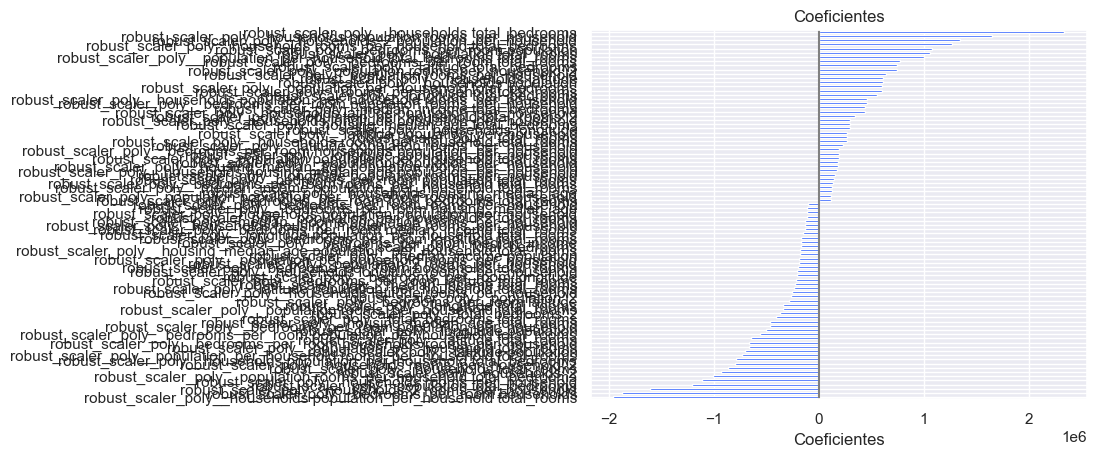

In [28]:
plot_coeficientes(coefs[~coefs['coeficiente'].between(-100_000, 100_000)])

In [29]:
target_transformer = PowerTransformer()

regressors = {
    'DummyRegressor':{
        'preprocessor':None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinnearRegression':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
  'LinnearRegression_target':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    },
    'LinnearRegression_grid_search':{
        'preprocessor':grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer':grid_search.best_estimator_.transformer,
    },
}    
resultados= {
    nome_modelo: treinar_e_validar_modelo_regressao(X,y,**regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.005689,0.004906,-0.000081,-77516.042766,-96239.705692,0.010595
1,DummyRegressor,0.003,0.004519,-0.000146,-75787.787194,-95217.629397,0.007519
2,DummyRegressor,0.003338,0.004458,-0.001737,-76753.598961,-96253.253947,0.007796
3,DummyRegressor,0.00381,0.005973,-0.000101,-76837.804811,-95983.885799,0.009784
4,DummyRegressor,0.003786,0.004139,-0.000114,-76617.245449,-96182.764729,0.007925
5,LinnearRegression,0.039141,0.011707,0.686163,-39594.450935,-53912.442857,0.050848
6,LinnearRegression,0.042426,0.012141,0.675204,-39981.022814,-54261.395997,0.054566
7,LinnearRegression,0.047632,0.019729,0.656061,-41894.722553,-56400.038547,0.067361
8,LinnearRegression,0.051215,0.011802,0.674797,-40532.02472,-54733.529419,0.063017
9,LinnearRegression,0.055861,0.013242,0.673042,-40427.576131,-54994.377046,0.069103


In [30]:
df_resultados.groupby('model').mean().sort_values(by='test_neg_root_mean_squared_error')	


,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.003925,0.004799,-0.000436,-76702.495836,-95975.447913,0.008724
LinnearRegression,0.047255,0.013724,0.673053,-40485.959431,-54860.356773,0.060979
LinnearRegression_target,0.062818,0.014173,0.689089,-37582.816079,-53495.691043,0.076991
LinnearRegression_grid_search,0.460948,0.029464,0.732059,-33926.422316,-49659.092404,0.490412


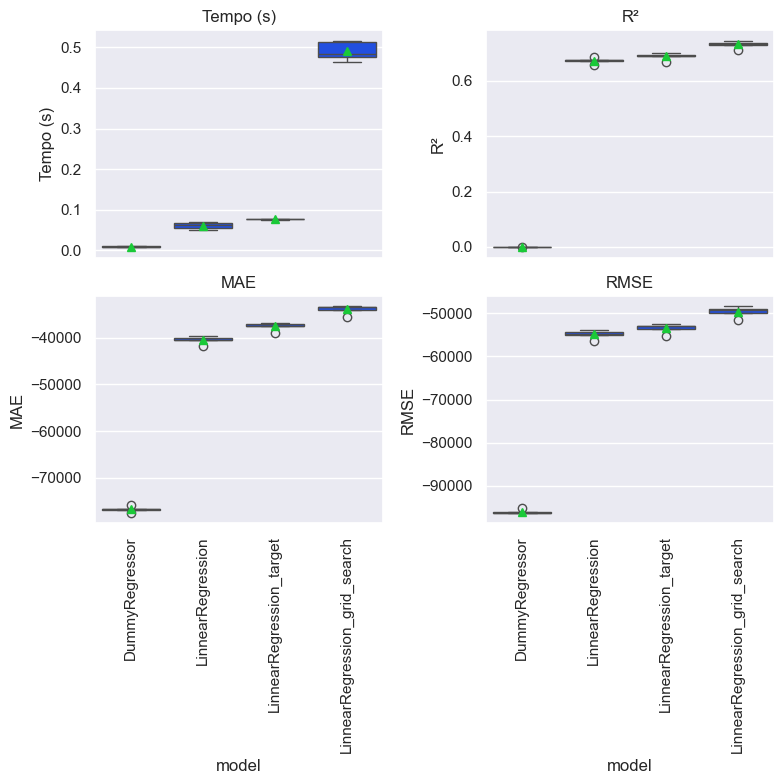

In [31]:
plot_comparar_metricas_modelos(df_resultados)

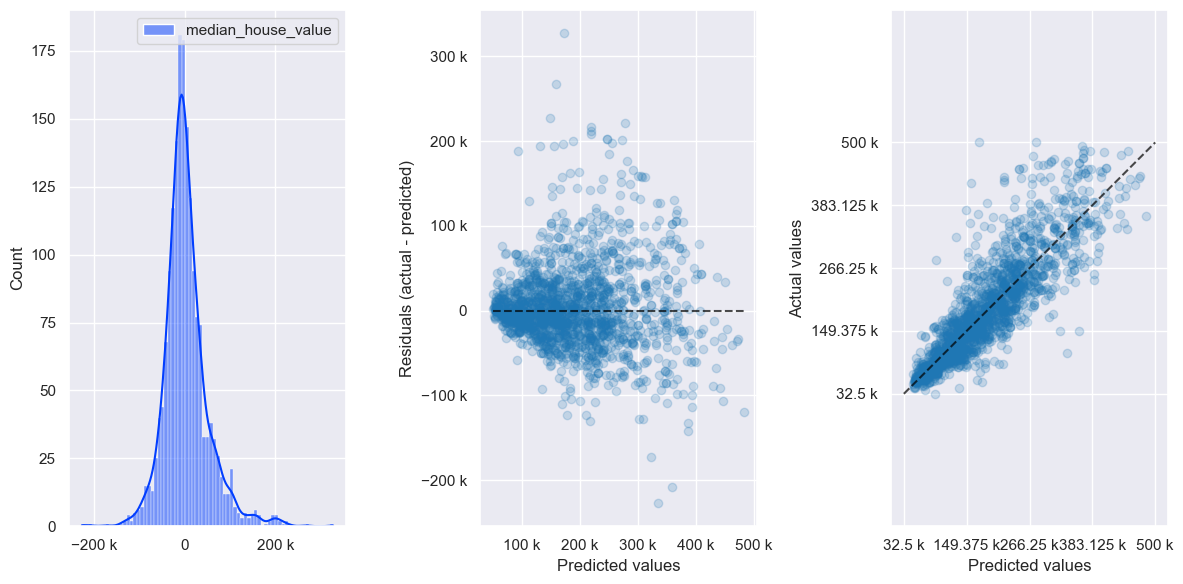

In [32]:
plot_residuos_estimador(grid_search.best_estimator_, X,y, fracao_amostra=0.1, eng_formatter=True)

Conclusão:

A regressão linear com polynomial features é uma técnica utilizada para modelar relações não-lineares entre variáveis preditoras (features) e a variável de resposta, ampliando a capacidade da regressão linear tradicional. Quando utilizamos polynomial features, introduzimos novas features elevando as variáveis originais a diferentes potências. Com base nos resultados o modelo se beneficia de features polinomiais de terceiro grau, indicando que há relações não lineares nos dados. 

Conclusion:

Linear regression with polynomial features is a technique used to model non-linear relationships between predictor variables (features) and the response variable, expanding the capacity of traditional linear regression. When we use polynomial features, we introduce new features by raising the original variables to different powers. Based on the results, the model benefits from third-degree polynomial features, indicating that there are non-linear relationships in the data.